# Indice

### 1- Introduccion

### 2 - EDA

### 2.1 - Analisis inicial de Datos.

### 3 - Preprocesamiento

### 3.1 - Sobre df_reviews

### 3.2 - Sobre df_games
 
### 4 - Surprise

### 4.1 - Modelo Benchmark

### 4.2 - Modelo SVD

### 4.2.1 - Cross Validation y distintos n de factor

### 4.2.1 - GridSearch

### 5 - Conclusiones Generales

### 6 - Para seguir investigando
__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________


### 1- Introduccion

### Tenemos informacion de la plataforma de juegos Steam. Nuestro objetivo con los dataset steam_games.json.gz y steam_reviews.json.gz, es entrenar un sistema de recomendacion que nos permita recomendar juegos a los usuarios que por lo menos realizaron una reseña, con el menor RMSE posible.

### 2 - EDA 

### 2.1 - Analisis inicial de Datos.

### Primero tenemos que descomprimir los archivos con la extencion .gz y luego transformarlos de .json a un dataset .csv (que permite manejar los datos con mas agilidad, con menos requerimientos de memoria y procesamiento).

In [2]:
#import gzip
#import pandas as pd

#def parse(path):
#    g = gzip.open(path, 'r')
#    for l in g:
#        yield eval(l)

### - steam_reviews.json.gz

In [3]:
#contador = 0
#data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
#n = 10
#for l in parse('steam_reviews.json.gz'):
#    if contador%n == 0:
#        data_reviews.append(l)
#    else:
#        pass
#    contador += 1


In [4]:
#data_reviews = pd.DataFrame(data_reviews)

In [5]:
#data_reviews.head(3)

In [6]:
#data_reviews.to_csv('new_data_reviews.csv')

### - steam_games.json.gz

In [7]:
#data_games = []
#for l in parse('steam_games.json.gz'):
#    data_games.append(l)
#data_games = pd.DataFrame(data_games)

In [8]:
#data_games.head(3)

In [9]:
#data_games.to_csv('new_data_games.csv')


### Ahora contamos con dos archivos csv de la plataforma de juegos Steam:

> ### __-new_data_games.csv:__ Tiene informacion sobre muchos de los juegos que ofrece la plataforma. Sus principales atributos son:
>> ### - "publisher" (editor) 
>> ### - "genres"(generos)
>> ### - "title"(nombre del juego)
>> ### - "release_date" (fecha en que se comenzo a comercializar)
>> ### - "tags" (etiquetas)
>> ### - "specs" (caracteristicas de juego)
>> ### - "id" (identificacion numerica y unica del juego)
>> ### - "developer" (desarrollador)
>> ### - "sentiment"(indica con un valor caracteristico en funcion de la valoracion que le pusieron los usuarios si es mas o menos valorado; tambien diferencia los casos en que no hay suficientes reseñas para evaluarlo)
>> ### - "metascore" ( valoracion numerica de 1 a 100, que tiene ese juego en la web www.metacritic.com)


> ### __-new_data_reviews.csv:__ Tiene informacion sobre las reseñas que realizaron los usuarios sobre los juegos que bajaron en dicha plataforma. Sus principales atributos son:
>> ### - "username" 
>> ### - "hours"(horas que ese usuario jugo a ese juego)
>> ### - "products" (es la cantidad de productos que el usuario compro en la plataforma)?
>> ### - "product_id"(identificacion numerica y unica del juego; es el equivalente al atributo "id" del archivo new_data_games.csv)
>> ### - "date" (fecha en que el usuario realizo la reseña)
>> ### - "text" (texto con observaciones del usuario)
>> ### - "found_funny" (las reseñas que realiza el usuario pueden ser marcadas como "funnys" por otros usuarios. Este indicador numerico es la cantidad de "calificaciones funny" que su reseña obtuvo)


### Es importante señalar que las reseñas que el usuario realiza solo puede calificarlas con "dedito arriba" o "dedito abajo". Puede agregar un texto para mas detalle y ademas recibir como "likes" a sus reseñas donde otros usuarios lo hacen a traves de un click sobre un link "funny".

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter, FixedLocator
import seaborn as sns
sns.set()

import pandas as pd

import gc # garbage collector

from surprise import Dataset # convertimos nuestro Dataframe en Dataset
                             # es la estructura de datos que utiliza Surprise!, para almacenar la Matriz de Utilidad
                             # es la forma de almacenar datos con menos memoria, ya que la Matriz de Utilidad es muy grande     
from surprise import Reader # lector de Surprise!
from surprise.model_selection import train_test_split
# quita calificacione de usuario-película de forma aleatoria s/ toda la matriz de utilidad, teniendo cuidado de no quitarle..
# ..todas las calificaciones a un usuario ni a una película

### - Para trabajar cargamos los dos archivos .csv que recien creamos. Vamos a trabajar con dos df; df_reviews y df_games.

In [11]:
df_reviews=pd.read_csv("new_data_reviews.csv")
df_reviews.head(3)

,Unnamed: 0,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN


In [12]:
df_games=pd.read_csv("new_data_games.csv")
df_games.head(3)

,Unnamed: 0,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",4.49,http://steamcommunity.com/app/761140/reviews/?...,['Single-player'],4.99,False,761140.0,Kotoshiro,NaN,NaN
1,1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free To Play,False,643980.0,Secret Level SRL,Mostly Positive,NaN
2,2,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"['Free to Play', 'Simulation', 'Sports', 'Casu...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free to Play,False,670290.0,Poolians.com,Mostly Positive,NaN


### - EDA sobre df_reviews

In [13]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779307 entries, 0 to 779306
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    779307 non-null  int64  
 1   username      779289 non-null  object 
 2   hours         776670 non-null  float64
 3   products      777741 non-null  float64
 4   product_id    779307 non-null  int64  
 5   page_order    779307 non-null  int64  
 6   date          779307 non-null  object 
 7   text          777468 non-null  object 
 8   early_access  779307 non-null  bool   
 9   page          779307 non-null  int64  
 10  user_id       317340 non-null  float64
 11  compensation  14588 non-null   object 
 12  found_funny   120164 non-null  float64
dtypes: bool(1), float64(4), int64(4), object(4)
memory usage: 72.1+ MB


In [14]:
df_reviews.describe().round(1)

,Unnamed: 0,hours,products,product_id,page_order,page,user_id,found_funny
count,779307.0,776670.0,777741.0,779307.0,779307.0,779307.0,3.173400e+05,120164.0
mean,389653.0,111.8,237.0,251489.8,4.4,893.6,7.656120e+16,7.7
std,224966.7,390.1,486.0,149975.4,2.9,1928.3,1.007694e+08,72.5
min,0.0,0.0,1.0,10.0,0.0,1.0,7.656120e+16,1.0
25%,194826.5,4.0,45.0,203770.0,2.0,53.0,7.656120e+16,1.0
50%,389653.0,15.3,110.0,252490.0,4.0,238.0,7.656120e+16,1.0
75%,584479.5,59.6,246.0,346110.0,7.0,829.0,7.656120e+16,3.0
max,779306.0,28164.0,13540.0,773900.0,9.0,18371.0,7.656120e+16,6524.0


 - __"hours"__

>- La cantidad de horas jugadas de los usuarios que realizaron estas reseñas son en total 776670.
>- La desviacion standard es 4 veces la media.
>- crecimiento exponencial en el ultimo cuartil. En ese cuarto cuartil las hs comprendidas van de 60 a 28164.

 - __"product_id"__

> Es un valor numerico pero que asigna referencia a un juego y solo a un juego en particular. Hace referencia al atributo "id" que tenemos en el df_games que se refiere solo a atributos del juego.

- A continuacion convertimos el atributo "username" a un Dtype int32. Era un Dtype object.

In [15]:
display(df_reviews.username.dtype)
df_reviews["username"]=df_reviews["username"].astype("category")
df_reviews["username"]=df_reviews["username"].cat.codes
df_reviews.username.dtype

dtype('O')

dtype('int32')

In [16]:
df_reviews.shape

(779307, 13)

In [17]:
print("Hay ",len(df_reviews['username'].unique()), "usuarios unicos")

Hay  540339 usuarios unicos


In [18]:
print("Hay ",779307,"reseñas" )

Hay  779307 reseñas


In [19]:
print(" De los", len(df_games['id'].unique()),"juegos de los que tenemos info en el archivo df_games.csv; solo hay reseñas de ",
                     len(df_reviews['product_id'].unique()), " de esos juegos")

 De los 32133 juegos de los que tenemos info en el archivo df_games.csv; solo hay reseñas de  12665  de esos juegos


- Vemos cantidad de reseñas por username. El usuario que mas reseñas realizo fue 213.

In [20]:
#plt.subplots(figsize=(18, 5))
#plt.hist(df_reviews["username"].value_counts, log= True)

#plt.xlabel('Cantidad de Usuarios',size=14)
#plt.ylabel('Cantidad de reseñas',size=14)
#plt.title("'Cantidad de reseñas por cantidad de usuarios'" ,size=18)
#plt.show() # Entre 0 y 500 usuarios son los que más calificaciones dieron

### - EDA sobre df_games

In [21]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32135 entries, 0 to 32134
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      32135 non-null  int64  
 1   publisher       24073 non-null  object 
 2   genres          28852 non-null  object 
 3   app_name        32133 non-null  object 
 4   title           30085 non-null  object 
 5   url             32135 non-null  object 
 6   release_date    30068 non-null  object 
 7   tags            31972 non-null  object 
 8   discount_price  225 non-null    float64
 9   reviews_url     32133 non-null  object 
 10  specs           31465 non-null  object 
 11  price           30758 non-null  object 
 12  early_access    32135 non-null  bool   
 13  id              32133 non-null  float64
 14  developer       28836 non-null  object 
 15  sentiment       24953 non-null  object 
 16  metascore       2607 non-null   float64
dtypes: bool(1), float64(3), int64(1

In [22]:
df_games.describe().round(1)

,Unnamed: 0,discount_price,id,metascore
count,32135.0,225.0,32133.0,2607.0
mean,16067.0,11.9,451757.4,72.3
std,9276.7,17.5,182714.0,10.8
min,0.0,0.5,10.0,20.0
25%,8033.5,1.4,329280.0,66.0
50%,16067.0,4.2,452060.0,74.0
75%,24100.5,22.7,593400.0,80.0
max,32134.0,140.0,2028850.0,96.0


### - El atributo "id" tiene un numero unico que representa al juego ("title") y se corresponde con el atributo "product_id" que esta en el df_reviews donde nos representa de que juego esta haciendo la reseña el usuario.

###  - __Atributo "sentiment"__

#### - El atributo "sentiment" por cada juego, simplifica en forma categorica el porcentaje de calificaciones positivas ("dedito arriba"), en relacion con las calificaciones negativas ("dedito abajo") y el total de las reseñas o calificaciones sobre ese juego en particular. Tambien en el caso de este archivo nos da informacion sobre si las reseñas sobre ese juego en particular son muy escazas y por lo tanto no las caracteriza (ej: 8 users reviews, etc).

In [23]:
pd.unique(df_games['sentiment'])

array([nan, 'Mostly Positive', 'Mixed', '1 user reviews',
       '3 user reviews', '8 user reviews', 'Very Positive',
       'Overwhelmingly Positive', '6 user reviews', '5 user reviews',
       '2 user reviews', 'Very Negative', 'Positive', 'Mostly Negative',
       '9 user reviews', 'Negative', '4 user reviews', '7 user reviews',
       'Overwhelmingly Negative'], dtype=object)

In [24]:
print(df_games['sentiment'].value_counts())

Mixed                      4103
Very Positive              3868
Positive                   3281
Mostly Positive            2744
1 user reviews             2496
2 user reviews             1756
3 user reviews             1231
4 user reviews              964
5 user reviews              846
Mostly Negative             802
6 user reviews              756
7 user reviews              619
8 user reviews              537
9 user reviews              488
Overwhelmingly Positive     303
Negative                    123
Very Negative                29
Overwhelmingly Negative       7
Name: sentiment, dtype: int64


Text(0.5, 1.0, 'Cantidad de juegos por tipo de caracterizacion del Atributo sentiment')

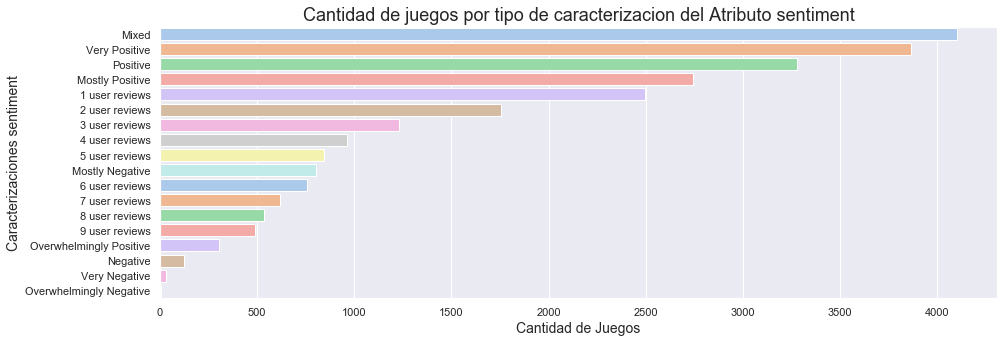

In [25]:
plt.subplots(figsize=(15, 5))

sns.countplot(data = df_games, y = 'sentiment', order = df_games['sentiment'].value_counts().index, palette='pastel')
plt.title('Número de Calificaciones por Tipo')

plt.xlabel('Cantidad de Juegos',size=14)
plt.ylabel('Caracterizaciones sentiment',size=14)
plt.title("Cantidad de juegos por tipo de caracterizacion del Atributo sentiment" ,size=18)

### 3 - Preprocesamiento
### 3.1 - Sobre df_reviews

In [26]:
display(df_reviews.isnull().sum())

Unnamed: 0           0
username             0
hours             2637
products          1566
product_id           0
page_order           0
date                 0
text              1839
early_access         0
page                 0
user_id         461967
compensation    764719
found_funny     659143
dtype: int64

### -Me parece conveniente sacar los valores nulos de horas jugadas.Son 2637 filas sobre un total de 779307; un 0.33%. 

### - Sobre los valores 0 hay dos preguntas que no tienen respuesta facil y que marcan una incongruencia. Porque no jugo ni una hora un juego que compro y porque escribio una reseña sobre un juego que no jugo? Aca seguramente tengamos que respondernos si el usuario lo juega por la plataforma Steam pero decide bajarlo a la pc y jugarlo desde ahi sin dejar reseñas sobre cuantas horas lo jugo y si los "logros" que va recolectando la plataforma no quiere que queden a la vista para sus posibles competidores. Se puede jugar los juegos comprados en la plataforma por fuera de la plataforma? Puedo probar en mi pc.

- Los valores nulos los convierto en 0.

In [27]:
df_reviews1=pd.DataFrame(df_reviews)
df_reviews1.hours.fillna(0,inplace=True)
display(df_reviews1.isnull().sum())
df_reviews1.shape

Unnamed: 0           0
username             0
hours                0
products          1566
product_id           0
page_order           0
date                 0
text              1839
early_access         0
page                 0
user_id         461967
compensation    764719
found_funny     659143
dtype: int64

(779307, 13)

### - De "hours" a "Ranking"


* Suponemos que si el tiempo de juego de un usuario para 'X' juego, es mayor a 22531.2, la calificación del usuario para 'X' juego es **5**.
* Si el tiempo de juego del usuario se encuentra entre 16898.4 y 22531.2 horas, la calificación se asume como **4**.
* Si el tiempo de juego del usuario se encuentra entre 11265.6 y 16898.4 horas, la calificación se asume como **3**.
* Si el tiempo de juego del usuario se encuentra entre 5632.8 y 11265.6 horas, la calificación se asume como **2**.
* Si el tiempo de juego del usuario se encuentra entre 1 y 5632.8 horas, la calificación se asume como **1**.

In [28]:
bins = [0, 5632.8, 11265.6, 16898.4, 22531.2, 28164]
labels =[1,2,3,4,5]
df_reviews1['ranking'] = pd.cut(df_reviews1['hours'], bins,labels=labels)
df_reviews1.head(3)

,Unnamed: 0,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny,ranking
0,0,62543,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN,1
1,1,26902,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN,1
2,2,434602,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN,1


- Transformamos cada usuario en un numero unico entero que lo identifica.

In [29]:
df_reviews2=pd.DataFrame(df_reviews1)

from sklearn.preprocessing import LabelEncoder

labelencoder=LabelEncoder()

df_reviews2["username"]=labelencoder.fit_transform(df_reviews2["username"])

df_reviews2.head(3)

,Unnamed: 0,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny,ranking
0,0,62544,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN,1
1,1,26903,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN,1
2,2,434603,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN,1


### - Sacamos las columnas que no vamos a utilizar.

In [30]:
df_reviews3=pd.DataFrame(df_reviews2)
df_reviews3=df_reviews3.drop(["Unnamed: 0","products","page_order","text", "early_access","page","user_id","compensation","date","found_funny"],
                             axis=1)
df_reviews3.head(3)

,username,hours,product_id,ranking
0,62544,0.1,725280,1
1,26903,13.2,328100,1
2,434603,0.1,725280,1


- Sacamos la columna "hours" que ya no la necesitamos.

In [31]:
df_reviews4= pd.DataFrame(df_reviews3)
df_reviews4=df_reviews3.drop(["hours"],axis=1)
df_reviews4

,username,product_id,ranking
0,62544,725280,1
1,26903,328100,1
2,434603,725280,1
3,347903,631920,1
4,503849,35140,1
...,...,...,...
779302,366850,252490,1
779303,242194,252490,1
779304,276241,252490,1
779305,168749,252490,1


- Necesitamos pasar la Dtype del atributo "ranking" de category a int.

In [32]:
df_reviews4.dtypes

username         int64
product_id       int64
ranking       category
dtype: object

In [33]:
df_reviews4['ranking']=df_reviews4['ranking'].astype("category")
df_reviews4['ranking']=df_reviews4['ranking'].cat.codes

In [34]:
df_reviews4.dtypes

username      int64
product_id    int64
ranking        int8
dtype: object

In [35]:
if True:
    df_reviews4.to_csv('df_reviews4.csv', index= False)

### 3.2 - Sobre df_games

 - Sacamos las columnas de los atributos que no vamos a utilizar.

In [36]:
df_games1=pd.DataFrame(df_games)
df_games1=df_games1.drop(["Unnamed: 0","url","reviews_url","discount_price","price","early_access","app_name"],axis=1)
df_games1=df_games1.rename(columns={"id": "product_id"})
df_games1.head(3)

,publisher,genres,title,release_date,tags,specs,product_id,developer,sentiment,metascore
0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,2018-01-04,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",['Single-player'],761140.0,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,2018-01-04,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...","['Single-player', 'Multi-player', 'Online Mult...",643980.0,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,2017-07-24,"['Free to Play', 'Simulation', 'Sports', 'Casu...","['Single-player', 'Multi-player', 'Online Mult...",670290.0,Poolians.com,Mostly Positive,NaN


### 4 - Surprise

In [37]:
df_svd = pd.read_csv('df_reviews4.csv')
print(df_svd.shape)
df_svd.head()

(779307, 3)


,username,product_id,ranking
0,62544,725280,0
1,26903,328100,0
2,434603,725280,0
3,347903,631920,0
4,503849,35140,0


In [38]:
df_svd.dtypes

username      int64
product_id    int64
ranking       int64
dtype: object

In [39]:
reader = Reader() 
# Para que pueda leer Surprise

* Un Dataset de Surprise, es muy parecido a un Dataframe de Pandas, sólo que es una estructura que utiliza menos memoria.

In [40]:
N_filas = 100000 # Limitamos el dataset a N_filas

data = Dataset.load_from_df(df_svd[['username','product_id','ranking']][:N_filas], reader) # Decimos cuáles y cuántas filas elegimos
# Cargamos un Dataset, a partir de un Dataframe

In [41]:
trainset, testset = train_test_split(data, test_size=.25) # OJO! Es el de Surprise. Es un Split del Dataset Completo

### - Entrenamiento

Vamos a entrenar un algoritmo SVD.

In [42]:
from surprise import SVD # OJO! Es también es de Surprise!
algo = SVD() # Usamos los hiperparámetros predeterminados

Entrenamos sobre el `trainset`

In [43]:
algo.fit(trainset)

# Entrenamos la Matriz de Utilidad de Train y de Test
# No hay y
# Entrena SVD sobre toda la Matriz de Utilidad (No s/ X e y)

Y predecimos sobre el `testset`. Notar que para predecir sobre un conjunto de test se usa la función `test`.

### - Prediccion

In [44]:
predictions = algo.test(testset)

In [45]:
predictions[5] # Predicción para 1 (para un usuario en particular)

# uid: Id del Usuario
# iid: Id de la película
# r_ui: calificación que le da a esa película en particular (la conocida)
# est: estimación de la calificación (obtenida de SVD)
# was imposible = False: fue posible calificar la película

Prediction(uid=35282, iid=270210, r_ui=0.0, est=1, details={'was_impossible': False})

En cambio, si queremos predecir para un usuario y un juego en particular, usamos la función `predict`

In [46]:
algo.predict(50805, 437920)

Prediction(uid=50805, iid=437920, r_ui=None, est=1, details={'was_impossible': False})

* r_ui=None: El usuario no calificó (reseña), dicho juego.

Exploremos un usuario, veamos cuáles juegos le gustaron y cuáles les recomienda el sistema.

Juegos que le gustaron

In [47]:
usuario = 26825
#hours = 6   # le pedimos peliculas a las que haya puesto 4 o 5 estrellas
#df_user = df_reviews4[(df_reviews4['username'] == usuario)] & (df_reviews4['hours'] >= hours)
#df_user = df_user.reset_index(drop=True)
#df_user['title'] = df_games['title'].loc[df_user.product_id].values
#df_user

Creamos donde vamos a guardar las recomendaciones para 1 usuario en particular

In [48]:
recomendaciones_usuario = df_reviews4.iloc[:50805].copy()
print(recomendaciones_usuario.shape)
recomendaciones_usuario.head(6)

(50805, 3)


,username,product_id,ranking
0,62544,725280,0
1,26903,328100,0
2,434603,725280,0
3,347903,631920,0
4,503849,35140,0
5,330406,288690,0


Vemos las recomendaciones que ya podemos hacerle a dicho usuario

In [49]:
usuario_vistas = df_reviews4[df_reviews3["username"] == usuario]
print(usuario_vistas.shape)
usuario_vistas.head(6)

(1, 3)


,username,product_id,ranking
505352,26825,230190,0


In [50]:
#recomendaciones_usuario.drop(usuario_vistas.product_id, inplace = True)
#recomendaciones_usuario = recomendaciones_usuario.reset_index()
#recomendaciones_usuario.head()

Y hacemos las recomendaciones, con el Id del juego específico, y ordenados de mayor a menor.  
Abajo la Recomendación con su valor.

In [51]:
recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario["product_id"].apply(lambda x: algo.predict(usuario, x).est)

In [53]:
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)
print(recomendaciones_usuario.head(10))
# Recomendaciones con valuaciones estimadas por debajo

    username  product_id  ranking  Estimate_Score
0      62544      725280        0               1
3     347903      631920        0               1
5     330406      288690        0               1
6     368958       35600        0               1
7     203839      620900        0               1
8     484673        1840        0               1
9      91336      671270        0               1
10    231313      288690        0               1
11    269338      308040        0               1
12    163342      302390        0               1


### - Evaluación

Para el conjunto de `testset`, evaluamos el error RMSE entre las predicciones y las verdaderas calificaciones que le habían dado a juegos.

In [85]:
from surprise import accuracy

accuracy.rmse(predictions)

RMSE: 1.0153


1.0152832117197643

### 4.1 - Modelo Benchmark

### - Hacemos un Cross Validation y distintos n de factores pero con todos los valores __del atributo "hours" sin el "ranking".__

In [86]:
N_filas = 100000 # Limitamos el dataset a N_filas

data = Dataset.load_from_df(df_reviews3[["username","product_id","hours"]][:N_filas], reader)

In [87]:
trainset, testset = train_test_split(data, test_size=.25)

In [88]:
algo = SVD() 

In [89]:
algo.fit(trainset)

In [90]:
accuracy.rmse(predictions)

RMSE: 1.0153


1.0152832117197643

### 4.2 - Modelo SVD

### 4.2.1 - Cross Validation y distintos n de factor

In [91]:
N_filas = 100000 # Limitamos el dataset a N_filas

data = Dataset.load_from_df(df_reviews4[["username","product_id","ranking"]][:N_filas], reader)

In [92]:
trainset, testset = train_test_split(data, test_size=.25)

In [93]:
algo = SVD() 

In [94]:
algo.fit(trainset)

In [95]:
accuracy.rmse(predictions)

RMSE: 1.0153


1.0152832117197643

In [96]:
from surprise.model_selection import cross_validate

rmse_test_means = []
factores = [1,2,4,8,16,32,64,128,256] # Determinamos cuántos valores latentes queremos descubrir

for factor in factores:
    print(f'\nNúmero de Factores: {factor}')
    algo = SVD(n_factors=factor)
    cv = cross_validate(algo, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))
    
# Va a hacer muchas Ejecuciones, y en c/u de ellas va a ir evaluando los resultados (éste es el proceso manual)


Número de Factores: 1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0155  1.0153  1.0148  1.0152  0.0003  
Fit time          2.29    2.22    2.26    2.26    0.03    
Test time         0.60    0.45    0.69    0.58    0.10    

Número de Factores: 2
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0167  1.0140  1.0148  1.0152  0.0012  
Fit time          2.30    2.14    2.24    2.23    0.07    
Test time         0.48    0.47    0.47    0.47    0.01    

Número de Factores: 4
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0146  1.0144  1.0166  1.0152  0.0010  
Fit time          2.29    2.20    2.36    2.29    0.06    
Test time         0.47    0.47    0.47    0.47    0.00    

Número de Factores: 8
Evaluating RMSE of algorithm SVD on 3 split(s).

    

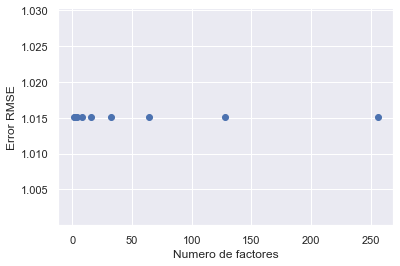

In [65]:
plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

### 4.2.1 - GridSearch

In [ ]:
# La otra manera de decubrir los valores latentes, pero de forma automática, es a través de Gridsearch

from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [5,50,100],'n_epochs': [5, 10,20], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1)
gs.fit(data)

# n_jobs = -1: usa todos los cores de procesamiento de la máquina

In [ ]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

### 5 - Conclusiones Generales

### 6 - Para seguir investigando